In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [10]:
df = pd.read_csv("../heart.csv")
print("Dataset shape:", df.shape)
X = df.drop("HeartDisease", axis=1)
y = df["HeartDisease"]
# Convertir columnas categóricas
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
print(f"Columnas categóricas: {categorical_cols}")
for col in categorical_cols:
    X[col] = pd.factorize(X[col])[0]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Datos preparados:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

Dataset shape: (918, 12)
Columnas categóricas: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
Datos preparados:
X_train: (734, 11), X_test: (184, 11)


In [11]:
def train_evaluate_model(X_train, y_train, X_test, y_test, model, param_grid, model_name):
    # pipeline
    pipe = Pipeline([
        ("scaler", MinMaxScaler()), 
        ("clf", model)
    ])
    
    # GridSearchCV
    grid = GridSearchCV(
        pipe, 
        param_grid, 
        cv=5, 
        scoring="roc_auc",
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_proba)
    
    print(f"{model_name} entrenado")
    print(f"   Mejores parámetros: {grid.best_params_}")
    print(f"   AUC: {auc:.3f}")
    return {
        "model": grid,
        "auc": auc,
        "best_params": grid.best_params_,
        "y_pred": y_pred,
        "y_proba": y_proba
    }

In [12]:
# Definir modelos y sus parámetros para GridSearch
models_config = {
    "LogisticRegression": (
        LogisticRegression(random_state=42, max_iter=1000),
        {"clf__C": [0.1, 1, 10], "clf__solver": ["liblinear"]}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {"clf__n_estimators": [50, 100], "clf__max_depth": [5, 10, None]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {"clf__n_neighbors": [3, 5, 7, 9]}
    ),
    "GradientBoosting": (
        GradientBoostingClassifier(random_state=42),
        {"clf__n_estimators": [50, 100], "clf__learning_rate": [0.1, 0.05]}
    ),
    "SVM": (
        SVC(probability=True, random_state=42),
        {"clf__C": [0.1, 1, 10], "clf__gamma": [0.01, 0.1]}
    )
}

In [13]:
results = {}
print("Entrenamiento de todos los modelos")
for model_name, (model, params) in models_config.items():
    print(f"\nEntrenando {model_name}")
    result = train_evaluate_model(X_train, y_train, X_test, y_test, model, params, model_name)
    results[model_name] = result

Entrenamiento de todos los modelos

Entrenando LogisticRegression
LogisticRegression entrenado
   Mejores parámetros: {'clf__C': 1, 'clf__solver': 'liblinear'}
   AUC: 0.899

Entrenando RandomForest
RandomForest entrenado
   Mejores parámetros: {'clf__max_depth': 5, 'clf__n_estimators': 50}
   AUC: 0.932

Entrenando KNN
KNN entrenado
   Mejores parámetros: {'clf__n_neighbors': 9}
   AUC: 0.910

Entrenando GradientBoosting
GradientBoosting entrenado
   Mejores parámetros: {'clf__learning_rate': 0.05, 'clf__n_estimators': 50}
   AUC: 0.929

Entrenando SVM
SVM entrenado
   Mejores parámetros: {'clf__C': 1, 'clf__gamma': 0.1}
   AUC: 0.894


In [14]:
ranking = pd.DataFrame([
    {"Modelo": name, "AUC": result["auc"], "Mejores Parámetros": str(result["best_params"])}
    for name, result in results.items()
]).sort_values("AUC", ascending=False)
print("Modelos dependiendo del resultado AUC:")
for i, (_, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}. {row['Modelo']}: AUC = {row['AUC']:.3f}")
ranking

Modelos dependiendo del resultado AUC:
1. RandomForest: AUC = 0.932
2. GradientBoosting: AUC = 0.929
3. KNN: AUC = 0.910
4. LogisticRegression: AUC = 0.899
5. SVM: AUC = 0.894


,Modelo,AUC,Mejores Parámetros
1,RandomForest,0.932090,"{'clf__max_depth': 5, 'clf__n_estimators': 50}"
3,GradientBoosting,0.928802,"{'clf__learning_rate': 0.05, 'clf__n_estimator..."
2,KNN,0.910031,{'clf__n_neighbors': 9}
0,LogisticRegression,0.898733,"{'clf__C': 1, 'clf__solver': 'liblinear'}"
4,SVM,0.894010,"{'clf__C': 1, 'clf__gamma': 0.1}"


c:\Users\Administrador\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Administrador\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Administrador\miniconda3\envs\ml_venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


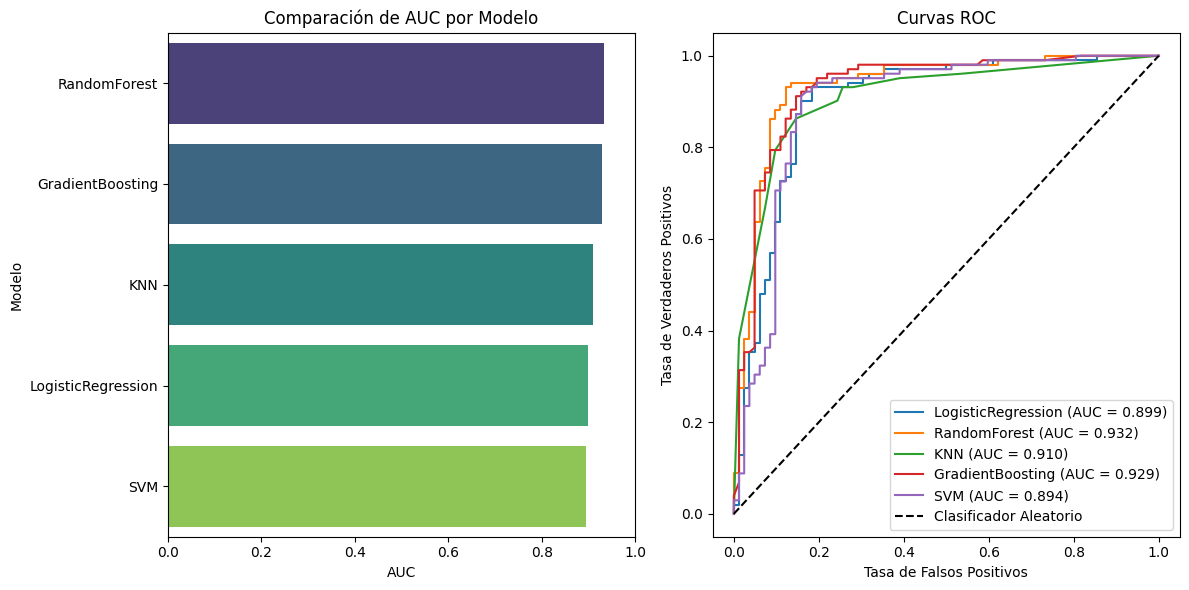

In [15]:
# Gráfico 
plt.figure(figsize=(12, 6))
# Barras AUC
plt.subplot(1, 2, 1)
sns.barplot(x='AUC', y='Modelo', data=ranking, palette='viridis')
plt.title('Comparación de AUC por Modelo')
plt.xlim(0, 1)
# Curvas ROC
plt.subplot(1, 2, 2)
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result["y_proba"])
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {result["auc"]:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curvas ROC')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
best_model_name = ranking.iloc[0]["Modelo"]
best_model = results[best_model_name]["model"]
print(f"Mejor modelo: {best_model_name}")
print(f"AUC: {results[best_model_name]['auc']:.3f}")
# Guardar modelo
joblib.dump(best_model, "../app/model.joblib")
print("Modelo guardado como: ../app/model.joblib")
# por separado 
scaler = MinMaxScaler()
scaler.fit(X_train)
joblib.dump(scaler, "../app/scaler.joblib")
print("Scaler guardado como: ../app/scaler.joblib")

Mejor modelo: RandomForest
AUC: 0.932
Modelo guardado como: ../app/model.joblib
Scaler guardado como: ../app/scaler.joblib


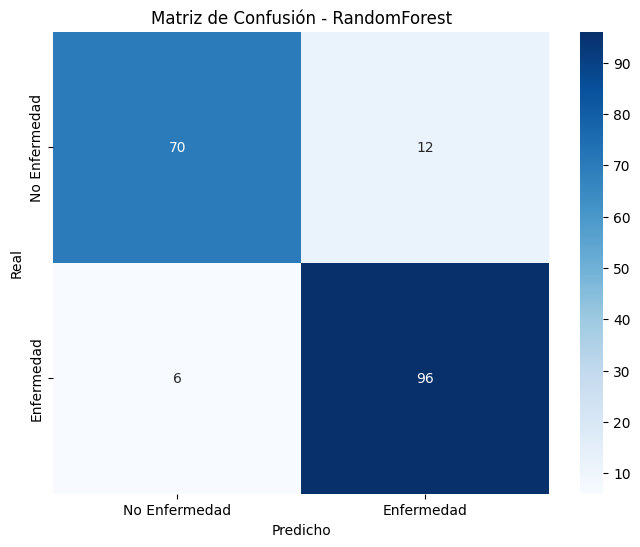

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.92      0.85      0.89        82
           1       0.89      0.94      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



In [17]:
# Matriz de confusión
best_result = results[best_model_name]
cm = confusion_matrix(y_test, best_result["y_pred"])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Enfermedad', 'Enfermedad'],
            yticklabels=['No Enfermedad', 'Enfermedad'])
plt.title(f'Matriz de Confusión - {best_model_name}')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()
print("Reporte de clasificación:")
print(classification_report(y_test, best_result["y_pred"]))